In [1]:
from visualization_fct import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import scale

# from bokeh.plotting import output_file, show, save
# from bokeh.mpl import to_bokeh

from bokeh.resources import CDN
from bokeh.embed import file_html
from bokeh.plotting import output_notebook, show, output_file
output_notebook()

import matplotlib.pyplot as plt  # , mpld3
import pyfits


np.random.seed(0)

# for now, no ratio in data (no rates A, B or C in this dataset)

only_flux = False
scale_data = True

hdulist = pyfits.open('../iirc_data/all_data_for_ml_properaverages.fits')
data = hdulist[1].data

#data=data[500:]

X_flux, X, data_thr, data_fr_en = get_iirc_data(
    data, only_flux=only_flux, scale_data=scale_data, thresholded=True)[:4]

# labels from gamma as in the paper:
a = np.array(data_thr['gamma'])
y = (a > 2.5).astype('int') + (a > 2).astype('int')


Loading BokehJS ...

<IPython.core.display.Javascript object>


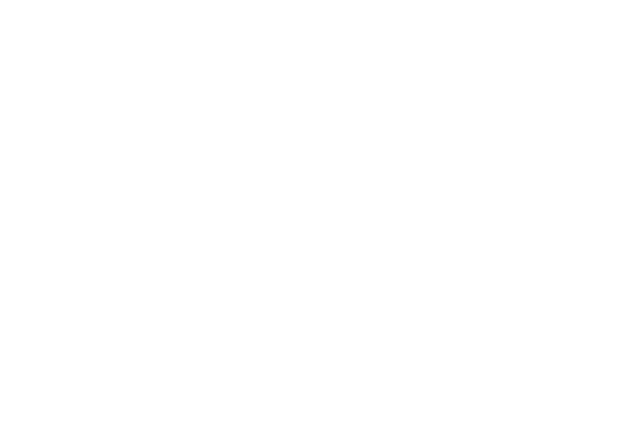

In [2]:
%matplotlib notebook
y.shape
data_thr['avg3'].values.dtype
plt.figure()
plt.plot(X_flux.max(axis=1))

<IPython.core.display.Javascript object>


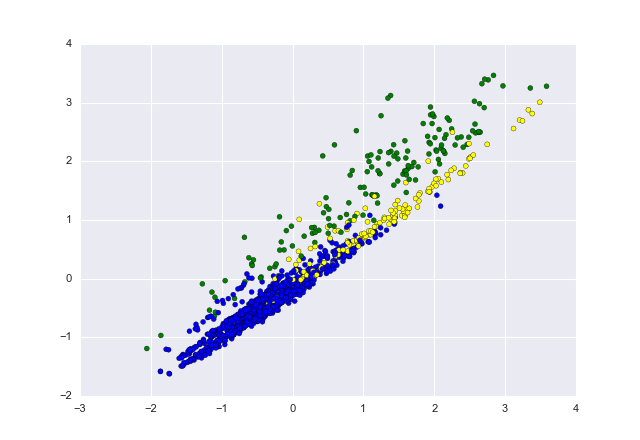

In [3]:
%matplotlib notebook
color = np.array(['blue', 'yellow', 'green'])
plt.figure()
plt.scatter(data_thr['avg2'].values, X_flux[:, 3], c=color[y])
plt.savefig('weird')

(2741,)


<IPython.core.display.Javascript object>


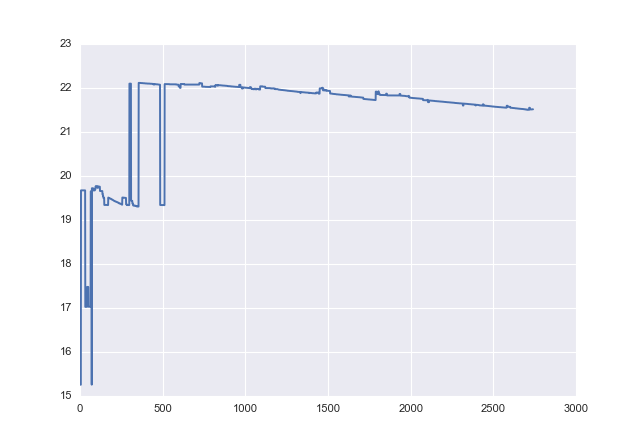

In [4]:
print data.shape
d = (data['en_lo'].byteswap().newbyteorder()
      + data['en_hi'].byteswap().newbyteorder()) / 2.
plt.figure()
plt.plot(d.mean(axis=1))
plt.show()

In [5]:
print data_thr.shape

(1168, 249)


<IPython.core.display.Javascript object>


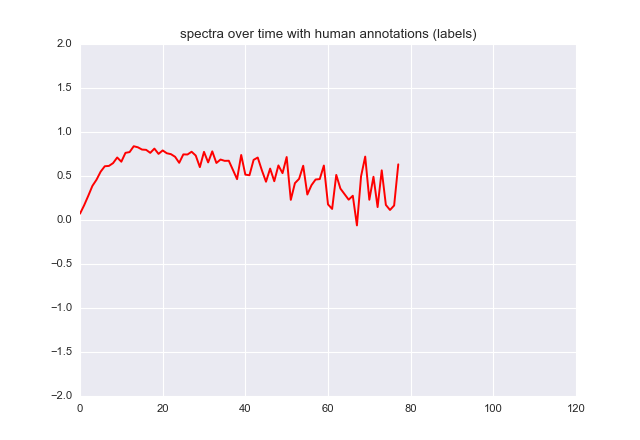

In [14]:
#%matplotlib notebook
# make video / widget of showing spectra over time
import matplotlib.animation as animation

En = np.concatenate([np.array(data_fr_en[name]).reshape(-1, 1) for name in data_fr_en.columns], axis=1)
colors = ['red', 'blue', 'green']

#%matplotlib auto  #  'osx', 'qt4', 'qt5', 'gtk3', 'wx', 'qt', 'gtk', 'tk'

fig, ax = plt.subplots()
ax.set_xlim(0, 120)
ax.set_ylim(-2, 2)
ax.set_title('spectra over time with human annotations (labels)')

#line, = ax.plot(En[0, :], X_flux[0, :])
line, = ax.plot(range(X_flux.shape[1]), X_flux[0, :])

def animate(i):
    # line.set_xdata(En[i, :])  # update the data
    line.set_ydata(X_flux[i, :])   # update the data
    line.set_color(colors[y[i]])
    return line,


## Init only required for blitting to give a clean slate.
#def init():
#    line.set_ydata(np.ma.array(x, mask=True))
#    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(1, 1000),#2000), #init_func=init,
                              interval=25, blit=True)
#plt.show()


ani.save('spectra_over_time.mp4', writer = 'mencoder', fps=30, extra_args=['-vcodec', 'libx264'])

In [ ]:
# visualize datapoints by plotting spectrum multiplied by energy (en_hi + en_lo)/2

fig, ax = plt.subplots()
#plt.axes(xlim=(-5, 5), ylim=(-1e-7, 1e-7))

line, = ax.plot((X_flux * En).max(axis=0))
line, = ax.plot((X_flux * En).min(axis=0))
#line, = ax.plot([En.min(), En.max()], [(X_flux * En).min(), (X_flux * En).max()])
#line, = ax.plot(En[0, :], X_flux[0, :] * En[0, :])
#line, = ax.plot(range(X_flux.shape[1]), X_flux[0, :] * En[0, :])

def animate(i):
    #line.set_xdata(En[i, :])  # update the data
    line.set_ydata(X_flux[i, :] * En[i, :])   # update the data
    line.set_color(colors[y[i]])
    return line,


# Init only required for blitting to give a clean slate.
def init():
    #line.set_xdata(En[0, :])
    line.set_ydata(X_flux[0, :] * En[0, :])
    line.set_color(colors[y[0]])
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(1, 2000), init_func=init,
                              interval=25, blit=True)
plt.show()

In [ ]:
%matplotlib notebook
plt.figure()
plt.plot(En[:, 0])
plt.show()

In [ ]:
lda = LDA(n_components=2).fit(X, y)
preds = lda.predict(X)
X_lda = lda.transform(X)
X_lda

In [ ]:
%matplotlib inline
clr = np.array(['blue', 'red', 'yellow'])
for j in range(3):
    plt.plot(X_lda[:, 0][y==j], X_lda[:, 1][y==j], '.', c=clr[j])
plt.show()

In [ ]:
plt.figure()
for j in range(3):
    plt.plot(X_lda[:, 0][preds==j], X_lda[:, 1][preds==j], '.', c=clr[j])
plt.show()

In [ ]:
np.mean(preds==y)

In [ ]:
lda.explained_variance_ratio_

In [ ]:
X[:,80]

In [ ]:
%matplotlib notebook
plt.figure()
plt.plot(lda.means_.T)
#plt.ylim([-1e-9,2e-8])
plt.show()

In [ ]:
%matplotlib notebook
plt.figure()
plt.plot(lda.scalings_)
plt.show()

In [ ]:
#try with X_flux instead of X
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit(X).transform(X)
%matplotlib notebook
plt.figure()
for j in range(3):
    plt.plot(X_pca[:, 0][y==j], X_pca[:, 1][y==j], '.')
plt.show()

In [ ]:
pca.explained_variance_ratio_

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=None)
X_pca = pca.fit(X).transform(X)
plt.figure()
print('pca.explained_variance_ratio_', pca.explained_variance_ratio_)
#df = pd.DataFrame(X_pca, columns=['1','2','3'])
#df['y'] = pd.Series(y).astype("category")
#scatter_matrix_seaborn(df, y='y', size=3)
#plt.plot(pca.explained_variance_ratio_)
plt.semilogy(pca.explained_variance_ratio_, '.')
plt.show()

In [ ]:
#pca.components_
plt.figure()
plt.plot(pca.components_[:3].T)
plt.show()

In [ ]:
#try with X_flux instead of X
X_withoutflux = X[:, 78:]
XX = X[y!=2]
yy = y[y!=2]
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(XX)
pca.components_[2, :80] = 0
pca.components_[2, 81:] = 0
X_pca = pca.transform(XX)
%matplotlib notebook
#plt.figure()
#for j in range(2):
#    plt.plot(X_pca[:, 0][yy==j], X_pca[:, 1][yy==j], '.')
#plt.show()

df = pd.DataFrame(X_pca, columns=['1','2', '3', '4'])
df['y'] = pd.Series(yy).astype("category")
from pandas.tools.plotting import scatter_matrix
col = [colors[x] for x in df['y']]
scatter_matrix(df, c=col)
 

In [ ]:
#pca.components_
plt.figure()
plt.bar(range(pca.components_.shape[1]), pca.components_[2].T)
plt.show()

In [ ]:
pca.explained_variance_ratio_

In [ ]:
#nmf:

from sklearn.decomposition import NMF
Xpos = X - X.min(axis=0)
model = NMF(n_components=2, init='random', random_state=0)
model.fit(Xpos) 
X_nmf = model.transform(Xpos)
for j in range(3):
    plt.plot(X_nmf[:, 0][y==j], X_pca[:, 1][y==j], '.')
plt.show()
print 'model.reconstruction_err_', model.reconstruction_err_
#print 'model.components_', model.components_

In [ ]:
model = NMF(n_components=2, init='random', random_state=0)
%matplotlib notebook
plt.figure()
model.fit(Xpos)
X_nmf = model.transform(Xpos)
for j in range(3):
    plt.plot(X_nmf[:, 0][preds==j], X_nmf[:, 1][preds==j], '.')#, c='k')
plt.show()

In [ ]:
plt.figure()
plt.plot(model.components_.T)
plt.show()

In [ ]:
model = NMF(n_components=3, init='random', random_state=0)
model.fit(Xpos)

colors = ['red', 'blue', 'yellow']

X_nmf = model.transform(Xpos)
df = pd.DataFrame(X_nmf, columns=['1','2', '3'])
df['y'] = pd.Series(y).astype("category")
#scatter_matrix_seaborn(df, y='y', size=3)

from pandas.tools.plotting import scatter_matrix
col = [colors[x] for x in df['y']]
scatter_matrix(df, c=col)#, alpha=0.2, figsize=(6, 6), diagonal='kde')


print 'model.reconstruction_err_', model.reconstruction_err_
#print 'model.components_', model.components_

In [ ]:
model.components_.shape

In [ ]:
plt.matshow(model.components_)

In [ ]:
model = NMF(n_components=4, init='random', random_state=0)
model.fit(Xpos) 
X_nmf = model.transform(Xpos)
df = pd.DataFrame(X_nmf, columns=['1','2', '3', '4'])
df['y'] = pd.Series(y).astype("category")

from pandas.tools.plotting import scatter_matrix
col = [colors[x] for x in df['y']]
scatter_matrix(df, c=col)#, alpha=0.2, figsize=(6, 6), diagonal='kde')

#scatter_matrix_seaborn(df, y='y', size=3)
print 'model.reconstruction_err_', model.reconstruction_err_
#print 'model.components_', model.components_

In [ ]:
err = []
n_comps = range(1, 11)
for n_comp in n_comps:
    model = NMF(n_components=n_comp, init='random', random_state=0)
    model.fit(Xpos) 
    err += [model.reconstruction_err_]
plt.figure()
plt.plot(n_comps, err)

In [ ]:
df

In [ ]:
p = bokeh_plot_cov(data_thr, x_name='5', y_name='0',
                   pred_name='y',
                   title=None,
                   plot_width=900, plot_height=300)
show(p)